DSC530: Week 11
11.2 Exercise
Marty Hoehler
5-26-24

# Exercise 13-1
First, we'll download data and import libraries as outlined in the text.  We're bringing in both cycle 6 (2002 data) and cycle 7 (2010 data).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

import thinkstats2
import thinkplot

import numpy as np
import pandas as pd

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

import nsfg

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")

import survival

download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)

In [2]:
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

Next, we will clean up the variables as recommended in the text.  The text also created "agemarry" and "age". 
These may be useful later, so I'll include them.
Note:  It appears that 'cmdivorcx' needs to be cleaned the same way cmmarrhx' needs to be, removing 9997, 9998, and 9999.

In [3]:
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6.cmdivorcx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6["agemarry"] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6["age"] = (resp6.cmintvw - resp6.cmbirth) / 12.0

resp7.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp7.cmdivorcx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp7["agemarry"] = (resp7.cmmarrhx - resp7.cmbirth) / 12.0
resp7["age"] = (resp7.cmintvw - resp7.cmbirth) / 12.0

Next, we'll calculate the duration of the marriages.  If a divorce didn't occur, we'll calculate the length of the marriage as of the date of the interview.
(Source for "np.where" function:  https://stackoverflow.com/questions/19913659/how-do-i-create-a-new-column-where-the-values-are-selected-based-on-existing-col)

In [4]:
resp6["divorced"] = -resp6['cmdivorcx'].isna()
resp7["divorced"] = -resp7['cmdivorcx'].isna()

resp6["marrdur"] = np.where(resp6['divorced'] == True, 
                            (resp6.cmdivorcx - resp6.cmmarrhx)/12.0, (resp6.cmintvw - resp6.cmmarrhx)/12.0) 

resp7["marrdur"] = np.where(resp7['divorced'] == True, 
                            (resp7.cmdivorcx - resp7.cmmarrhx)/12.0, (resp7.cmintvw - resp7.cmmarrhx)/12.0)

Since we are studying the length of marriages, we will filter the dataframe to only those respondants who have married.
We'll also concatenate the two datasets together.
(Concat() source:  https://pandas.pydata.org/docs/user_guide/merging.html)

#### Note:
It appears that there are some cases where 'evrmarry' is true, but there is no marriage date.  This causes errors in our marriage duration caculation, so we'll also remove lines where 'cmmarrhx' is NaN.

It also appears that there are some cases where the date of divorce is earlier than the date of marriage.  Since this doesn't make sense, we'll remove those as well.

In [15]:
resp6mar = resp6[resp6['evrmarry']==True]
resp7mar = resp7[resp7['evrmarry']==True]
resp6mar = resp6mar[resp6mar['cmmarrhx'].isna() == False]
resp7mar = resp7mar[resp7mar['cmmarrhx'].isna() == False]

resp6mar = resp6mar[resp6mar['cmmarrhx'] <= resp6mar['cmdivorcx']]
resp7mar = resp7mar[resp7mar['cmmarrhx'] <= resp7mar['cmdivorcx']]

resps = pd.concat([resp6mar, resp7mar], ignore_index=True)

resps

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives,divorced,marrdur,wgtq1q16
0,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11,True,8.583333,NaN
1,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11,True,2.333333,NaN
2,11700,822,True,1015.0,1051.0,2,4666.559600,1236,16.083333,34.500000,68,6,13,True,3.000000,NaN
3,7354,896,True,1071.0,1178.0,5,3026.730179,1235,14.583333,28.250000,74,7,14,True,8.916667,NaN
4,5083,789,True,1064.0,1168.0,2,3374.535218,1236,22.916667,37.250000,65,6,13,True,8.666667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,35098,838,True,1097.0,1304.0,3,696.364149,1325,21.583333,40.583333,69,6,13,True,17.250000,696.364149
2517,28665,893,True,1199.0,1236.0,0,8813.673474,1291,25.500000,33.166667,74,7,14,True,3.083333,8813.673474
2518,26336,815,True,1014.0,1038.0,3,17707.840330,1286,16.583333,39.250000,67,6,13,True,2.000000,17707.840330
2519,33324,878,True,1095.0,1278.0,2,3061.801499,1283,18.083333,33.750000,73,7,14,True,15.250000,3061.801499


#### Define Functions
We will use the text's definition for EstimateHazard().

In [6]:
from collections import Counter


def EstimateHazardFunction(complete, ongoing, label="", verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype=float)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

Next, we define the "complete" and "ongoing" sets.  
- "Complete" is the duration for those who are divorced.
- "Ongoing" is the duration for those who are still married.

In [17]:
complete = resps[resps.divorced==True].marrdur
ongoing = resps[resps.divorced==False].marrdur

hf = EstimateHazardFunction(complete, ongoing)

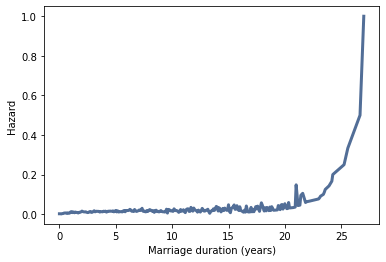

In [18]:
thinkplot.Plot(hf)
thinkplot.Config(xlabel="Marriage duration (years)", ylabel="Hazard")

Our text mentions that the hazard function can get over-estimated at the tail end, where there is less data available.  In this case, there are fewer respondants that have been married 25 or more years.  (It's rare for someone in a relationship that long to still be young enough to become pregnant.)  So the hazard function gets noisy at this area.

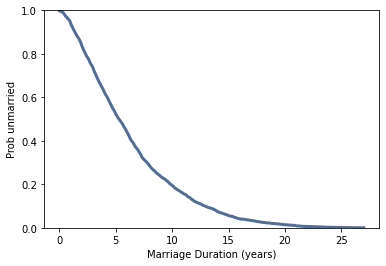

In [19]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel="Marriage Duration (years)", ylabel="Prob unmarried", ylim=[0, 1])